# Single-Cell RNA Seq Example

## Outline

- [Dev Setup](#dev-setup)
- [Understanding the mechanism of action of a drug using causal inference](#understanding-the-mechanism-of-action-of-a-drug-using-causal-inference)
    - [Experimental design](#experimental-design)
    - [Data ingestion](#data-ingestion)
    - [Data preprocessing](#data-preprocessing)
- [Goal: Understand the effects that the cancer drug candidate Pracinostat SB939 has on other target genes](#goal-understand-the-effects-that-the-cancer-drug-candidate-pracinostat-sb939-has-on-other-target-genes)
    - [Exploratory data analysis](#exploratory-data-analysis)
- [Causal Probabilistic Program](#causal-probabilistic-program)
    - [Model Description](#model-description)
    - [Fitting observed data](#fitting-observed-data)
    - [Predictions on unseen cells](#predictions-on-unseen-cells)
- [Computing causal queries](#computing-causal-queries)
    - [Causal Query: Average treatment effect (ATE)](#causal-query-average-treatment-effect-ate)
    - [Causal Query: Conditional average treatment effect (CATE)](#causal-query-conditional-average-treatment-effect-cate)
- [References](#references)





## Dev setup

Here, we install the necessary Pytorch, Pyro, and ChiRho dependencies for this example.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
!pip install scanpy pybiomart numpy==1.23 seaborn==0.12.2 ## add single cell dependencies

In [3]:
import os
import math
import numpy as np
import scipy.sparse
import pandas as pd
import scanpy as sc
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
from pyro.infer.autoguide import AutoNormal
from pyro.nn import PyroModule
import pyro.distributions as dist
from IPython.display import Image
import torch

from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from chirho.observational.handlers import condition

pyro.clear_param_store()
pyro.set_rng_seed(1234)
pyro.settings.set(module_local_params=True)

sns.set_style("white")

## Understanding the mechanism of action of a drug using causal inference

### Experimental design

We analyze the SciPlex3 dataset from Srivatsan (2020), which uses "nuclear hashing" to measure global transcriptional responses to over 4,000 unique perturbations at single-cell resolution. This hashing technique is summarized below:

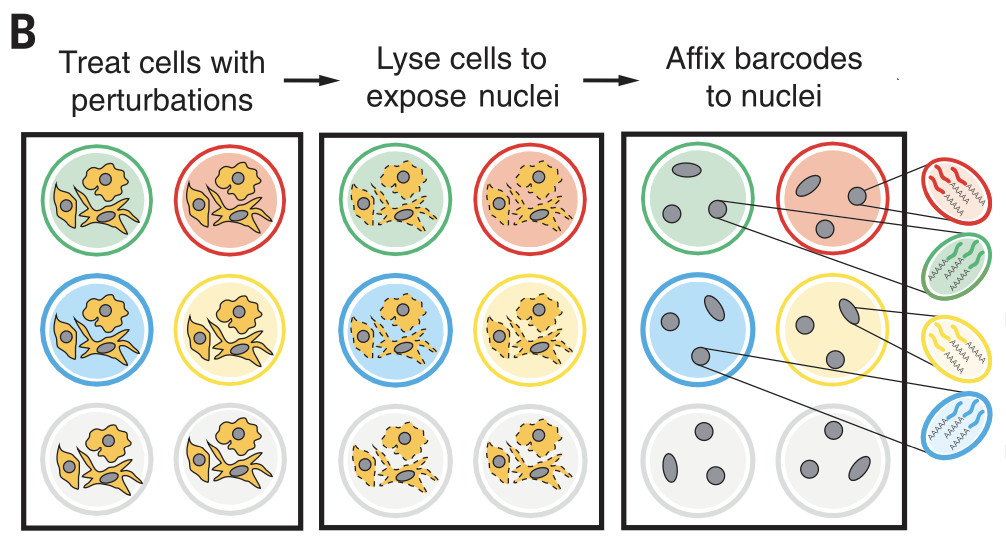

In [4]:
# Figure 1B from Srivatsan (2020)
# Cells corresponding to different perturbations are lysed in-well, their nuclei labeled with well-specific “hash” oligos,
# followed by fixation, pooling, and sci-RNA-seq.
Image('./figures/sciplex_fig1b.png', width=500)

Using this experimental setup, Srivatsan et al. profiled the effects of 188 drugs on three different cancer cell types: MCF7, K562, and A549. Each cell in this dataset is unperturbed (`Vehicle`) or randomly treated with a drug from a library of 188 drug perburbations (`product_name`) at 4 different dosages (`dose`): $10^1, 10^2, 10^3, 10^4$ nM. After 24hrs, the expressions of each gene are measured. Hence, apart from technical confounders such as batch effects, the differences in gene expression between the treated and untreated cells are caused by the drug perturbation. Figure 3A summarizes this combinatorial experimental design.

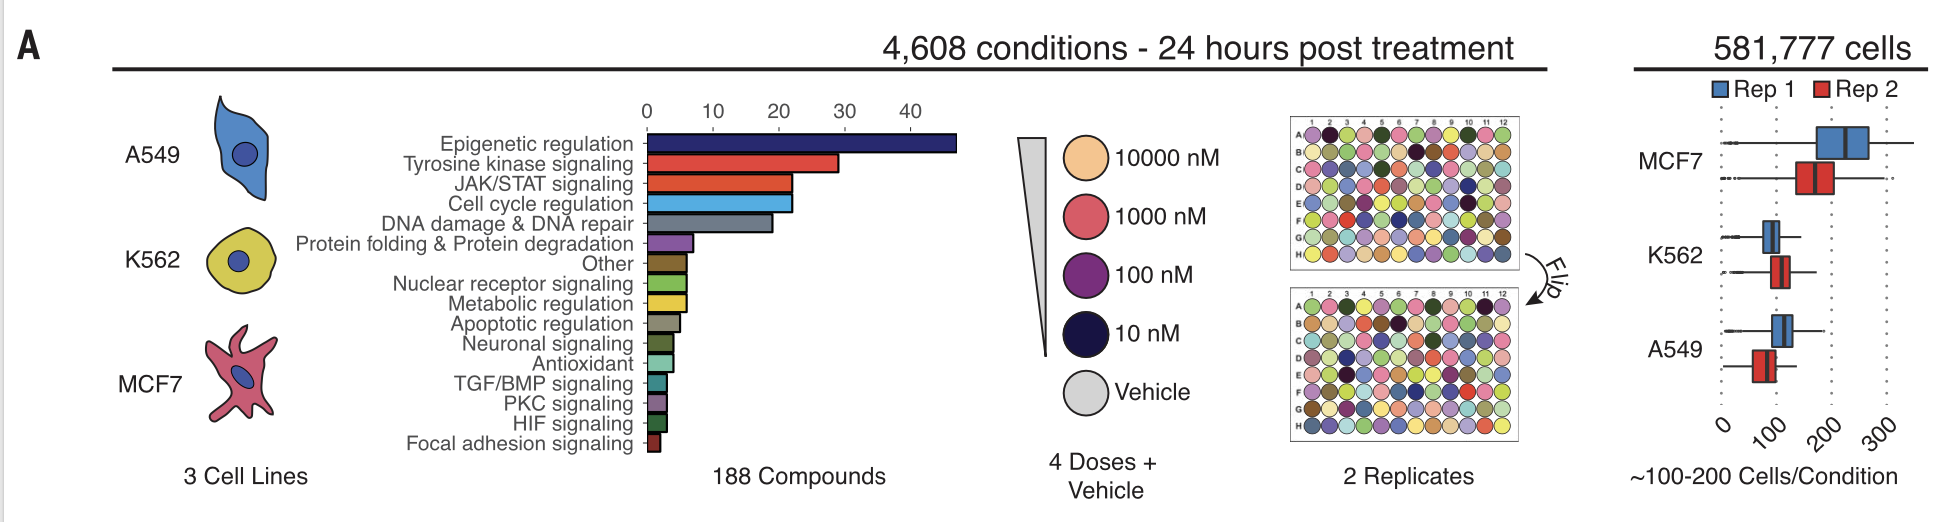

In [5]:
Image('./figures/sciplex_fig3a.png', width=1000)

### Data ingestion

scPerturb (https://github.com/sanderlab/scPerturb/) provides pre-processed single-cell RNA seq datasets, including the SciPlex3 dataset from Srivatsan (2020). Unfortunately, there is an issue in scPerturb with processing the SciPlex3 dataset (https://github.com/sanderlab/scPerturb/issues/7). We fix the bug in their script (https://github.com/sanderlab/scPerturb/blob/master/dataset_processing/SrivatsanTrapnell2020.py) below.

In [6]:
# Download raw data if doesn't already exist
if os.path.exists("SrivatsanTrapnell2020_sciplex3_debugged.h5"):
    anndata = sc.read_h5ad("SrivatsanTrapnell2020_sciplex3_debugged.h5")
else:
    # Download and unzip 3 files files from here:
    # https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4150378
    # (1) GSM4150378_sciPlex3_A549_MCF7_K562_screen_UMI.count.matrix.gz
    # (2) GSM4150378_sciPlex3_A549_MCF7_K562_screen_gene.annotations.txt.gz
    # (3) GSM4150378_sciPlex3_pData.txt.gz

    # Cach raw zip files
    os.system(
        "wget -c https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4150nnn/GSM4150378/suppl/GSM4150378_sciPlex3_A549_MCF7_K562_screen_UMI.count.matrix.gz"
    )
    os.system(
        "wget -c https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4150nnn/GSM4150378/suppl/GSM4150378_sciPlex3_A549_MCF7_K562_screen_gene.annotations.txt.gz"
    )

    os.system(
        "wget -c https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4150nnn/GSM4150378/suppl/GSM4150378_sciPlex3_pData.txt.gz"
    )

    # unzip files
    os.system("gunzip GSM4150378_sciPlex3_A549_MCF7_K562_screen_UMI.count.matrix.gz")
    os.system("gunzip GSM4150378_sciPlex3_A549_MCF7_K562_screen_gene.annotations.txt.gz")
    os.system("gunzip GSM4150378_sciPlex3_pData.txt.gz")

    var = pd.read_csv(
        "GSM4150378_sciPlex3_A549_MCF7_K562_screen_gene.annotations.txt",
        sep=" ",
    )
    var.columns = ["gene_id", "gene_name"]

    var = var.set_index("gene_name")

    obs2 = pd.read_csv("GSM4150378_sciPlex3_pData.txt", sep=" ")

    UMI_counts = pd.read_csv(
        "GSM4150378_sciPlex3_A549_MCF7_K562_screen_UMI.count.matrix", sep="\t", header=None
    )

    X = scipy.sparse.csr_matrix(
        (UMI_counts[2], (UMI_counts[1] - 1, UMI_counts[0] - 1)), shape=(len(obs2), len(var))
    )  # this may crash your kernel

    UMI_counts = None  # save on memory
    anndata = sc.AnnData(X, obs=obs2, var=var)

    # reform var
    anndata.var.index = anndata.var.index.rename("gene_symbol")
    anndata.var["ensembl_gene_id"] = [x.split(".")[0] for x in anndata.var["gene_id"]]
    anndata.obs["dose_unit"] = "nM"
    anndata.obs["celltype"] = [
        "alveolar basal epithelial cells"
        if line == "A549"
        else "mammary epithelial cells"
        if line == "MCF7"
        else "lymphoblasts"
        if line == "K562"
        else "None"
        for line in anndata.obs.cell_type
    ]
    anndata.obs["disease"] = [
        "lung adenocarcinoma"
        if line == "A549"
        else "breast adenocarcinoma"
        if line == "MCF7"
        else "chronic myelogenous leukemia"
        if line == "K562"
        else "None"
        for line in anndata.obs.cell_type
    ]
    anndata.write("SrivatsanTrapnell2020_sciplex3_debugged.h5")

/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
# Data is 12GB
!du -sh *h5

 12G	SrivatsanTrapnell2020_sciplex3_debugged.h5


### Data preprocessing

We preprocess the data as follows:
- Filter out cells that have unknown cell type
- Only include measurements at the 24hr timepoint (retains ~90% of the dataset)
- Restrict to human genes since all cells are from human cell lines
- Filter out genes that are expressed in fewer than 10 cells
- Filter out cells that have fewer than 200 expressed genes
- Mitochondrial ratio quality (based on visual inspection)
- Read counts

In [8]:
# Remove unknown cell types
anndata = anndata[~anndata.obs['cell_type'].isnull()]

# Filter out to only 24hr observations (~90% of the data remains)
anndata = anndata[anndata.obs['time_point'] == 24]

# Restrict to genes in human genome
annot = sc.queries.biomart_annotations(
    "hsapiens", ["ensembl_gene_id", "hgnc_symbol"]
)
annot = annot.dropna()
anndata = anndata[:, anndata.var['ensembl_gene_id'].isin(annot['ensembl_gene_id'].values)]

# Filter out genes that are expressed in less than 10 cells
sc.pp.filter_genes(anndata, min_cells=10)

# Filter out cells that express less than 200 genes
sc.pp.filter_cells(anndata, min_genes=200)

/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


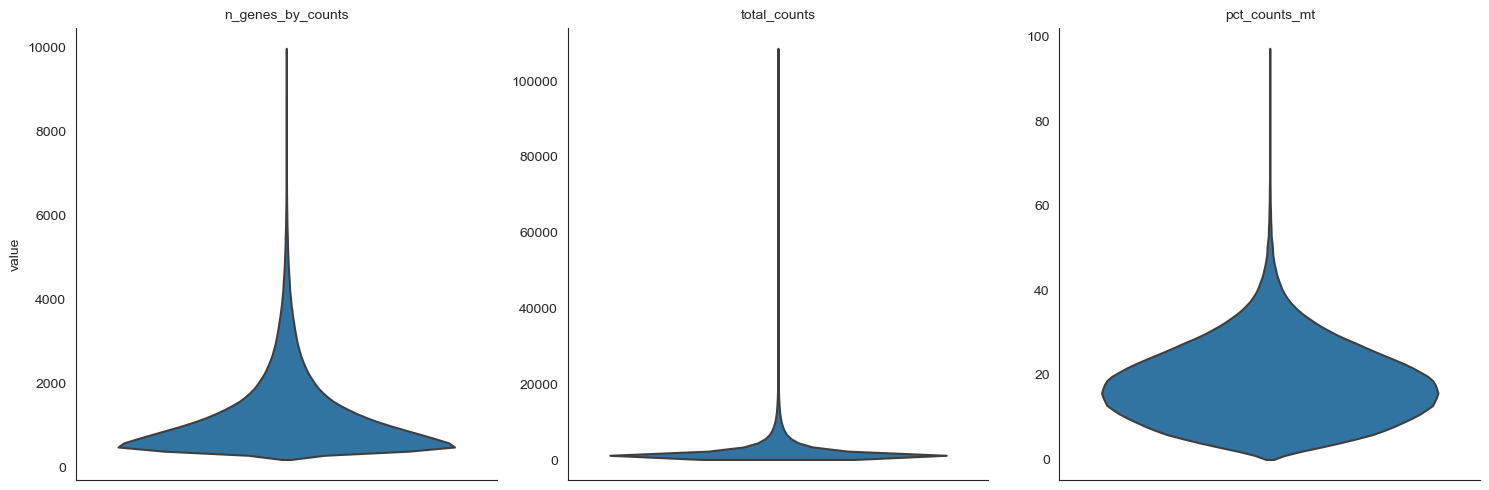

In [9]:
# Trim outliers by 
# 1. Mitochondrial ratio quality 
# 2. total read counts
# 3. number of genes per cell
anndata.var["mt"] = anndata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    anndata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

anndata.var_names_make_unique()
# Quality plots to identify outliers
sc.pl.violin(
    anndata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.3,
    multi_panel=True,
    stripplot=False
)

In [10]:
# define outliers and do the filtering for the sciplex data
# with arbitrary cutoffs 
anndata.obs['outlier_mt'] = anndata.obs.pct_counts_mt > 60
anndata.obs['outlier_total'] = anndata.obs.total_counts > 20000
anndata.obs['outlier_ngenes'] = anndata.obs.n_genes_by_counts > 6000

print('%u cells with high %% of mitochondrial genes' % (sum(anndata.obs['outlier_mt'])))
print('%u cells with large total counts' % (sum(anndata.obs['outlier_total'])))
print('%u cells with large number of genes' % (sum(anndata.obs['outlier_ngenes'])))

anndata = anndata[~anndata.obs['outlier_mt'], :]
anndata = anndata[~anndata.obs['outlier_total'], :]
anndata = anndata[~anndata.obs['outlier_ngenes'], :]
sc.pp.filter_genes(anndata, min_cells=1)

655 cells with high % of mitochondrial genes
2713 cells with large total counts
1481 cells with large number of genes


/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


## Goal: Understand the effects that the cancer drug candidate Pracinostat SB939 has on other target genes

We choose a particular drug (Pracinostat (SB939)), which is currently in a Phase II clinical trial for treating T cell lymphoma. We start our analysis by looking at several summary statistics and visualizations of this drug. Then, we use `ChiRho` to estimate the causal effect of this drug on gene expression levels. 

Below we look at which pathway Pracinostat (SB939) targets.


In [11]:
anndata.obs[anndata.obs.product_name.str.contains("Pracin")][['target']].drop_duplicates().reset_index(drop=True)

,target
0,HDAC


Histone deacetylase (HDAC) inhibitors are anti-cancer agents that can induce death, apoptosis, and cell cycle arrest in cancer cells Kim (2011). HDAC inhibitors have been shown to modify the activity of many transcription factors. Some of these include NCOA3, MYB, E2F1, KLF1, FEN1, GATA1, HNF4A, XRCC6, NFκB, PCNA, TP53, RB1, Runx, SF1 Sp3, STAT, GTF2E1, TCF7L2, YY1 (Drummond 2005, Yang 2007). We focus on modeling the changes in expression of genes  associated with these transcription factors in response to Pracinostat (`target_genes`). We would like to understand which of the genes in `target_genes` are (1) most affected by Pracinostat, (2) upregulated or downregulated, and (3) how the effects of Pracinostat on these genes vary across different cell types.

In [12]:
drug_target = "Pracinostat (SB939)"
drug_data = anndata[anndata.obs.product_name.str.contains("Pracinostat|Vehi")]
anndata = None # save on memory

In [13]:
target_genes = [
    'NCOA3', 'MYB', 'E2F1', 'KLF1', 'FEN1', 'GATA1', 'HNF4A', 'XRCC6', 'NFKB1', 'PCNA', 'TP53', 'RB1', 'RUNX1', 'SF1', 'SP3', 'STAT1', 'GTF2E1', 'TCF7L2', 'YY1', 'SIRT2'    
]

#### Exploratory data analysis

In [14]:
# Use pearson residuals for better gene visualization
# see https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02451-7
sc.experimental.pp.highly_variable_genes(
    drug_data, flavor="pearson_residuals", n_top_genes=10000
)

/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/scanpy/experimental/pp/_highly_variable_genes.py:67: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


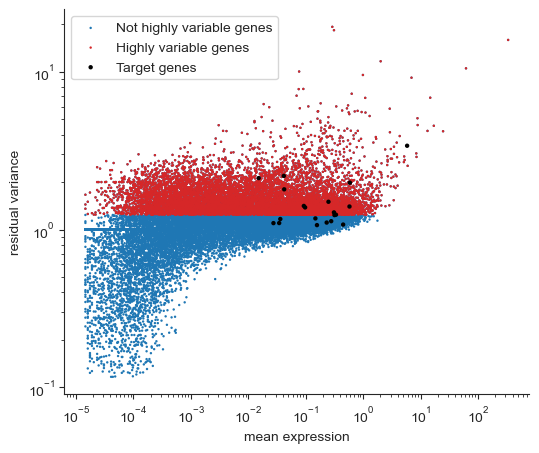

In [15]:
fig, ax = plt.subplots(1, figsize=(6, 5))

hvgs = drug_data.var["highly_variable"]

ax.scatter(
    drug_data.var["mean_counts"], drug_data.var["residual_variances"], s=3, edgecolor="none",
    label='Not highly variable genes'
)
ax.scatter(
    drug_data.var["mean_counts"][hvgs],
    drug_data.var["residual_variances"][hvgs],
    c="tab:red",
    label="Highly variable genes",
    s=3,
    edgecolor="none",
)
ax.scatter(
    drug_data.var["mean_counts"][target_genes],
    drug_data.var["residual_variances"][target_genes],
    c="k",
    label="Target genes",
    s=10,
    edgecolor="none",
)

ax.set_xscale("log")
ax.set_xlabel("mean expression")
ax.set_yscale("log")
ax.set_ylabel("residual variance")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

ax.legend()

In [16]:
# Filter to highly variable genes
drug_data = drug_data[:, drug_data.var["highly_variable"]]

# Remove low variance genes in target_genes based on pearson residuals
target_genes = np.intersect1d(target_genes, drug_data.var_names[drug_data.var.highly_variable])
# target_genes = np.array(drug_data.var_names[drug_data.var.highly_variable])

Let's look at how each cell clusters based on cell type and if the cell was given the drug or not using a Uniform Manifold Approximation and Projection (UMAP) embedding of the highly variable genes.

In [17]:
# The UMAP function does a visualization using 'X' in the anndata object
# We save the raw counts for later use
drug_data.layers["raw"] = drug_data.X.copy()

# Now, 'X' refers to pearson residuals 
sc.experimental.pp.normalize_pearson_residuals(drug_data)

# Log1p normalize of the data (used for UMAP visual)
drug_data.layers["log1p"] = np.log1p(
    sc.pp.normalize_total(drug_data, inplace=False)["X"]
)

sc.pp.neighbors(drug_data, n_neighbors=30, n_pcs=30)
sc.tl.umap(drug_data)

/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


         Falling back to preprocessing with `sc.pp.pca` and default params.


/var/folders/1n/rv21b_n10gx0tp5_zz33z7qc0000gn/T/ipykernel_50725/397955117.py:9: RuntimeWarning: invalid value encountered in log1p
  drug_data.layers["log1p"] = np.log1p(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In the UMAP latent space, we see a clear clustering of cells around both cell type and if the cell was given the drug or not.

/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


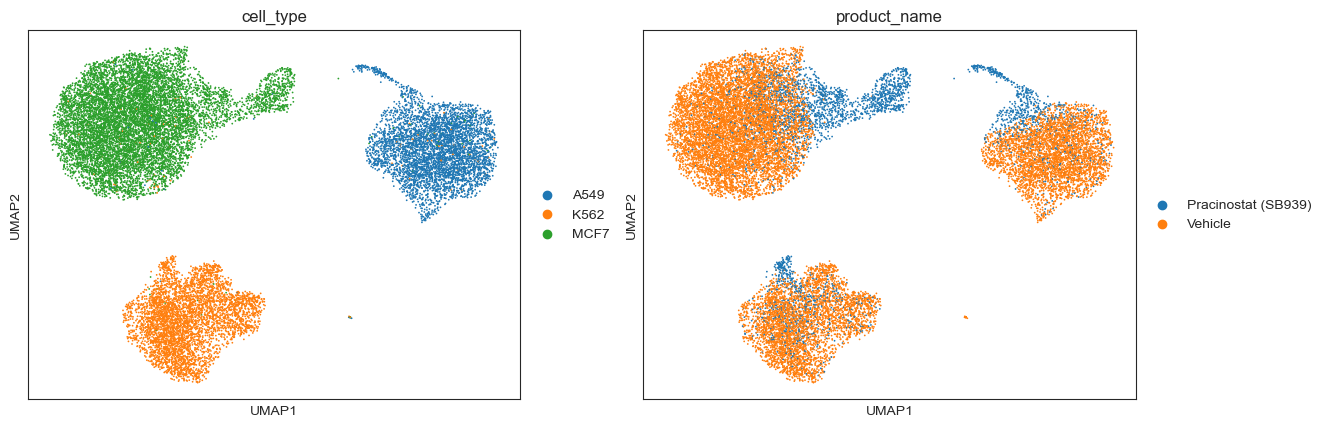

In [18]:
# Visualize expression pattern per cell in UMAP
sc.pl.umap(drug_data, layer='log1p',
           color=['cell_type', 'product_name'])

Let's look at how each of these genes are expressed in the dataset. We plot the distribution of log expression levels for each gene, stratified by cell type and log treatment dosages. We see that the expression levels of these genes vary across cell types, and that treatment with Pracinostat (SB939) induces changes in expression levels for some genes but not others.

In [39]:
def plot_average_expression(data, gene_names):    
    drug_expression_df = pd.DataFrame(data[:, gene_names].layers['log1p'].toarray(), columns=gene_names)
    drug_expression_df['log10dose'] = np.log10(data.obs['dose'].values)
    drug_expression_df = drug_expression_df.replace(-np.inf, 0)
    data.obs['log10dose'] = drug_expression_df['log10dose'].values
    drug_expression_df['cell_type'] = data.obs['cell_type'].values
    avg_expression = drug_expression_df.groupby(by=['cell_type', 'log10dose']).mean().reset_index()
    avg_expression = avg_expression.melt(id_vars=['cell_type', 'log10dose'])
    avg_expression.rename({'variable': 'gene_name', 'value': 'avg_expression'}, inplace=True, axis=1)
    
    fig, ax = plt.subplots(2, 6, figsize=(24, 8))
    
    for i, gene in enumerate(gene_names):
        curr_ax = ax[i // 6][i % 6]
        if gene in avg_expression.gene_name.values:
            sns.lineplot(data=avg_expression[avg_expression.gene_name == gene],
                         x='log10dose', y='avg_expression', hue='cell_type', ax=curr_ax, marker='o')
            curr_ax.set_title(gene)
            curr_ax.set_xlabel('Log Dose')
            curr_ax.set_ylabel('Log Expression')
            curr_ax.legend(loc='upper left')
    plt.tight_layout()

/var/folders/1n/rv21b_n10gx0tp5_zz33z7qc0000gn/T/ipykernel_50725/3836804433.py:3: RuntimeWarning: divide by zero encountered in log10
  drug_expression_df['log10dose'] = np.log10(data.obs['dose'].values)


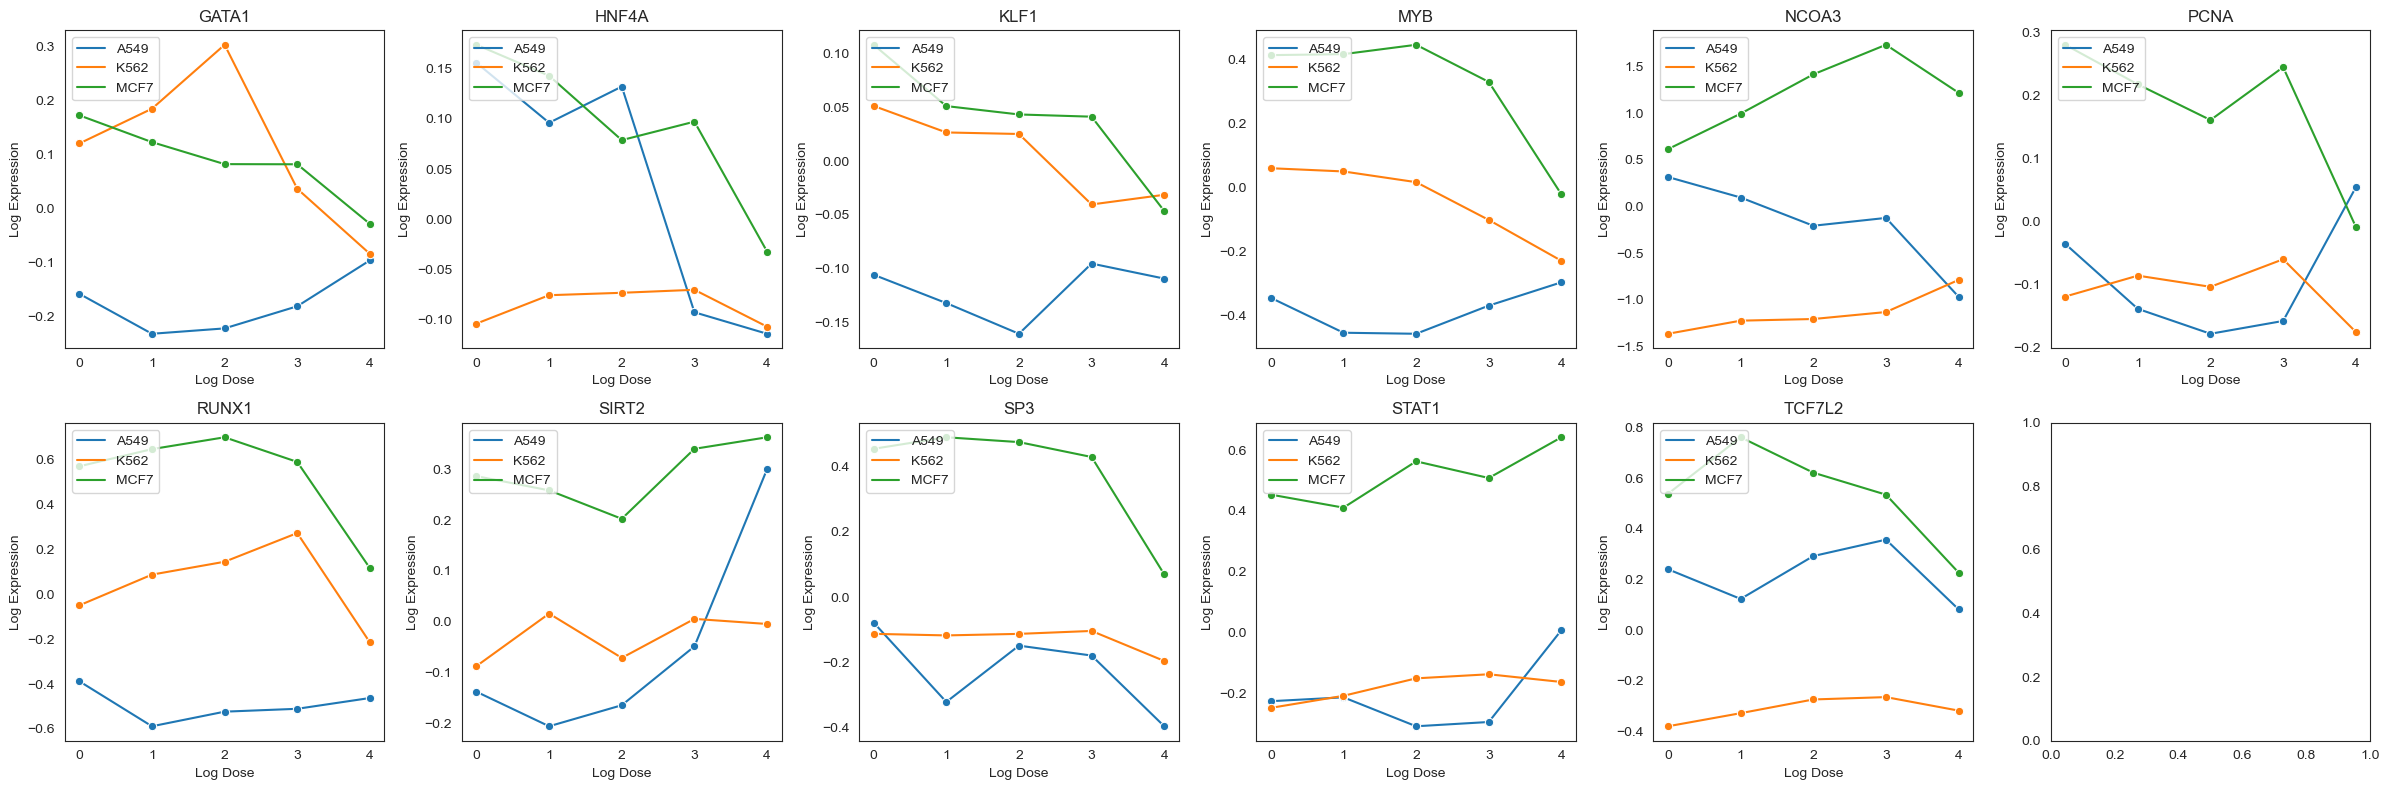

In [40]:
plot_average_expression(drug_data, target_genes)

TODO: fill in once target genes selected and provide biological interpretation

## Causal Probabilistic Program

### Model Description
In the plots above, we did not control for technical covariates (e.g., cell plate, replicate number, etc.). Here we fit a generalized linear model with a Poission likelihood to account for the heavy-tailed count nature of the data. We also include interactions between genes and confounders (e.g., cell type, read depth, etc.) to understand how treatment effects vary across cell types and experimental conditions, and model unobserved confounders. Our model is defined as follows:

$$
\begin{align*}
    Z_{nk} &\sim \mathcal{N}(0, 1), \quad{1 \leq k \leq K} \quad (\text{$K$ unobserved confounders for cell}) \\
    \tilde{X}_n &= (X_n, \ Z_n) \in \mathbb{R}^{p + K} \quad (\text{observed and unobserved confounders}) \\
    c_g &\sim \mathcal{N}(0, 1) \quad (\text{intercept}) \\
    \tau_{g} &\sim \mathcal{N}(0, 1) \quad (\text{additive treatment effect}) \\
    \theta_{gi} &\sim \mathcal{N}(0, 1 / \sqrt{p + K}), \quad{1 \leq i \leq p + K} \quad (\text{additive confounder effect}) \\
    \eta_{gi} &\sim \mathcal{N}(0, 1 / \sqrt{p + K}), \quad{1 \leq i \leq p + K} \quad (\text{confounder-treatment interaction effect}) \\
    \log \mu_{ng} &= c_g + \tau_{g} T_n + \theta_{g}^T \tilde{X}_n + \eta_{g}^T (\tilde{X}_n \odot T_n) \quad (\text{Poisson rate}) \\
    Y_{ng} &\sim \text{Poisson}(\mu_{ng}) \quad (\text{Poisson likelihood}) \\

\end{align*}
$$
where $\odot$ denotes elementwise multiplication, $p$ the number of confounders, $T_n$ treatment, $X_n$ observed confounders, and $Y_{ng}$ gene expression counts for cell $n$ and gene $g$.

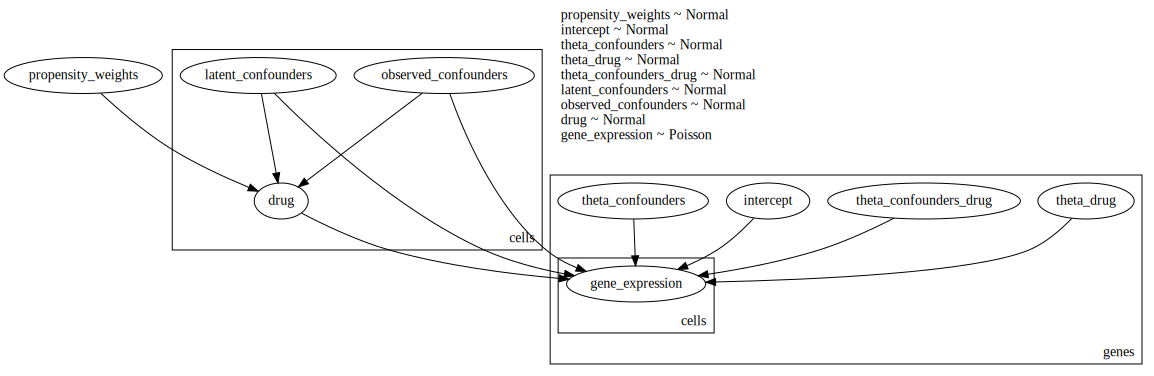

In [21]:
class DrugPerturbationModel(PyroModule):
    def __init__(self, num_cells: int, num_genes: int, num_observed_confounders: int, num_latent_confounders: int = 3):
        super().__init__()
        self.num_cells = num_cells
        self.num_genes = num_genes
        self.num_observed_confounders = num_observed_confounders
        self.num_latent_confounders = num_latent_confounders
        self.num_confounders = num_observed_confounders + num_latent_confounders
        self.cell_plate = pyro.plate("cells", self.num_cells, dim=-2)
        self.gene_plate = pyro.plate("genes", self.num_genes, dim=-1)

    def forward(self, mask: bool = False):
        prior_scale = 1 / math.sqrt(self.num_confounders)
        propensity_weights = pyro.sample("propensity_weights", dist.Normal(0, prior_scale).expand((self.num_confounders, )).to_event(1))

        # Sample regression weights for each gene
        with self.gene_plate:
            intercept = pyro.sample("intercept", dist.Normal(0, 1))
            theta_confounders = pyro.sample("theta_confounders", dist.Normal(0, prior_scale).expand((self.num_confounders,)).to_event(1)) # G x F
            theta_drug = pyro.sample("theta_drug", dist.Normal(0, 1))
            theta_confounders_drug = pyro.sample("theta_confounders_drug", dist.Normal(0, prior_scale).expand((self.num_confounders,)).to_event(1)) # G x F
         
        # Compute likelihood
        with self.cell_plate:
            # Sample treatment and confounders (remove from log_prob since we'll always conditioned on them when mask = False)
            latent_confounders = pyro.sample("latent_confounders", dist.Normal(0, 1).expand((self.num_latent_confounders,)).to_event(1))
            observed_confounders = pyro.sample("observed_confounders", dist.Normal(0, 1).expand((self.num_observed_confounders,)).mask(mask).to_event(1))
            observed_confounders = observed_confounders.expand(latent_confounders.shape[:-1] + observed_confounders.shape[-1:])
            confounders = torch.cat([observed_confounders, latent_confounders], dim=-1)  # torch.cat doesn't broadcast

            treatment_mean = torch.einsum("...ngp,...p->...ng", confounders, propensity_weights)
            T = torch.relu(pyro.sample("drug", dist.Normal(treatment_mean, 1)))
            with self.gene_plate:
                # Confounding effects
                confounder_variation = intercept + torch.einsum("...ngp,...gp->...ng", confounders, theta_confounders) # N x G

                # Drug dose treatment effects
                treatment_variation = theta_drug * T + torch.einsum("...ngp,...ng,...gp->...ng", confounders, T, theta_confounders_drug) # N x G
                mean = confounder_variation + treatment_variation # N x G
                expressions = pyro.sample("gene_expression", dist.Poisson(rate=torch.exp(mean)))
        return expressions
    
pyro.render_model(DrugPerturbationModel(10, 10, 10, 3), render_distributions=True, render_params=True)

### Fitting observed data

We further process the data for modeling by (1) one-hot encoding categorical confounders, (2) converting dosages to log dosage amounts, (3) splitting the data in training and test.

In [22]:
# Restrict to top 1000 genes or those in target_genes
is_top1k_mask_or_target = sc.experimental.pp.highly_variable_genes(
    drug_data, flavor="pearson_residuals", n_top_genes=1000,
    inplace=False
)['highly_variable'].values | drug_data.var.index.isin(target_genes)

drug_data = drug_data[:, is_top1k_mask_or_target]

/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/scanpy/experimental/pp/_highly_variable_genes.py:73: UserWarning: `flavor='pearson_residuals'` expects raw count data, but non-integers were found.
  warnings.warn(
/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/scanpy/experimental/pp/_highly_variable_genes.py:125: RuntimeWarning: invalid value encountered in sqrt
  residuals = (X_dense - mu) / np.sqrt(mu + mu**2 / theta)


In [23]:
# Make data matrices
X_confounders = pd.get_dummies(drug_data.obs[['cell_type', 'replicate', 'culture_plate', 'pcr_plate', 'well_oligo']], dtype=np.int32).reset_index(drop=True)

# Control for sequencing depth
log_umi = np.log(drug_data.obs['n.umi'].values)
scaled_log_umi = (log_umi - np.mean(log_umi)) / log_umi.std()
X_confounders['depth_proxy'] = scaled_log_umi

# For each drug, input log dose as a feature
T_all = pd.get_dummies(drug_data.obs[['product_name']], dtype=np.int32).reset_index(drop=True)
T_all = T_all.mul(np.log10(drug_data.obs['dose'].values + 1), axis=0)

# Get treatment, confounders, response for all gene expressions
X_drug_control = torch.tensor(X_confounders.values, dtype=torch.float32)
T_drug_control = torch.tensor(T_all[f'product_name_{drug_target}'].values, dtype=torch.float32)
Y_drug_control = torch.tensor(drug_data.layers['raw'].toarray(), dtype=torch.float32)

# Split into training and test set
N_drug_control = X_drug_control.shape[0]
train_mask = torch.tensor(np.random.choice([True, False], size=N_drug_control, p=[0.8, 0.2]))
X_train = X_drug_control[train_mask]
T_train = T_drug_control[train_mask]
Y_train = Y_drug_control[train_mask]
X_test = X_drug_control[~train_mask]
T_test = T_drug_control[~train_mask]
Y_test = Y_drug_control[~train_mask]

In [24]:
class ConditionedDrugModel(PyroModule):
    def __init__(self, model: DrugPerturbationModel):
        super().__init__()
        self.model = model

    def forward(self, X, T, Y, **kwargs):
        with condition(data=dict(observed_confounders=X[:, None, :], drug=T[..., None], gene_expression=Y)):
            return self.model(**kwargs)

We fit our model using stochastic variational inference with a mean-field variational family.

In [25]:
model_train = ConditionedDrugModel(
    DrugPerturbationModel(num_cells=Y_train.shape[0], num_genes=Y_train.shape[1], num_observed_confounders=X_train.shape[1])
)

guide_train = AutoNormal(model_train)
elbo = pyro.infer.Trace_ELBO()(model_train, guide_train)

# initialize parameters
elbo(X=X_train, T=T_train, Y=Y_train)

adam = torch.optim.Adam(elbo.parameters(), lr=0.03)

# Do gradient steps
for step in range(2000):
    adam.zero_grad()
    loss = elbo(X=X_train, T=T_train, Y=Y_train)
    loss.backward()
    adam.step()
    if step % 250 == 0:
        print("[iteration %04d] loss: %.4f" % (step, loss))

/opt/homebrew/anaconda3/envs/basis/lib/python3.10/site-packages/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'genes', 'cells'}
  warnings.warn(


[iteration 0000] loss: 46261348.0000
[iteration 0250] loss: 3679841.5000
[iteration 0500] loss: 3314622.5000
[iteration 0750] loss: 3301108.5000
[iteration 1000] loss: 3219031.0000
[iteration 1250] loss: 3187581.0000
[iteration 1500] loss: 3189542.0000
[iteration 1750] loss: 3176242.5000


### Predictions on unseen cells

As we see below, our predictions of gene expressions are quite poor. However, this is not very suprising because we are using a linear model, and not conditioning on more cell and gene features.

In [26]:
model_test_obs = ConditionedDrugModel(
    DrugPerturbationModel(num_cells=Y_test.shape[0], num_genes=Y_test.shape[1], num_observed_confounders=X_test.shape[1])
)

guide_train.eval()
guide_test_obs = pyro.infer.autoguide.AutoGuideList(model_test_obs)
guide_test_obs.append(pyro.poutine.block(guide_train, hide=['latent_confounders', 'latent_confounders_unconstrained', 'cells', 'genes']))
guide_test_obs.append(AutoNormal(pyro.poutine.block(model_test_obs, expose=['latent_confounders', 'cells', 'genes'])))

elbo = pyro.infer.Trace_ELBO()(model_test_obs, guide_test_obs)

# initialize parameters
elbo(X=X_test, T=T_test, Y=Y_test)

adam = torch.optim.Adam(elbo.parameters(), lr=0.03)

# Do gradient steps
for step in range(2000):
    adam.zero_grad()
    loss = elbo(X=X_test, T=T_test, Y=Y_test)
    loss.backward()
    adam.step()
    if step % 250 == 0:
        print("[iteration %04d] loss: %.4f" % (step, loss))

[iteration 0000] loss: 1052792.6250
[iteration 0250] loss: 828275.3125
[iteration 0500] loss: 827545.7500
[iteration 0750] loss: 827259.1875
[iteration 1000] loss: 827243.3125
[iteration 1250] loss: 827745.1250
[iteration 1500] loss: 827053.2500
[iteration 1750] loss: 828031.4375


In [27]:
predictive = pyro.infer.Predictive(model_test_obs, guide=guide_test_obs, num_samples=500)
predictive_samples = predictive(X=X_test, T=T_test, Y=None)
test_avg = predictive_samples['gene_expression'].mean(dim=0)

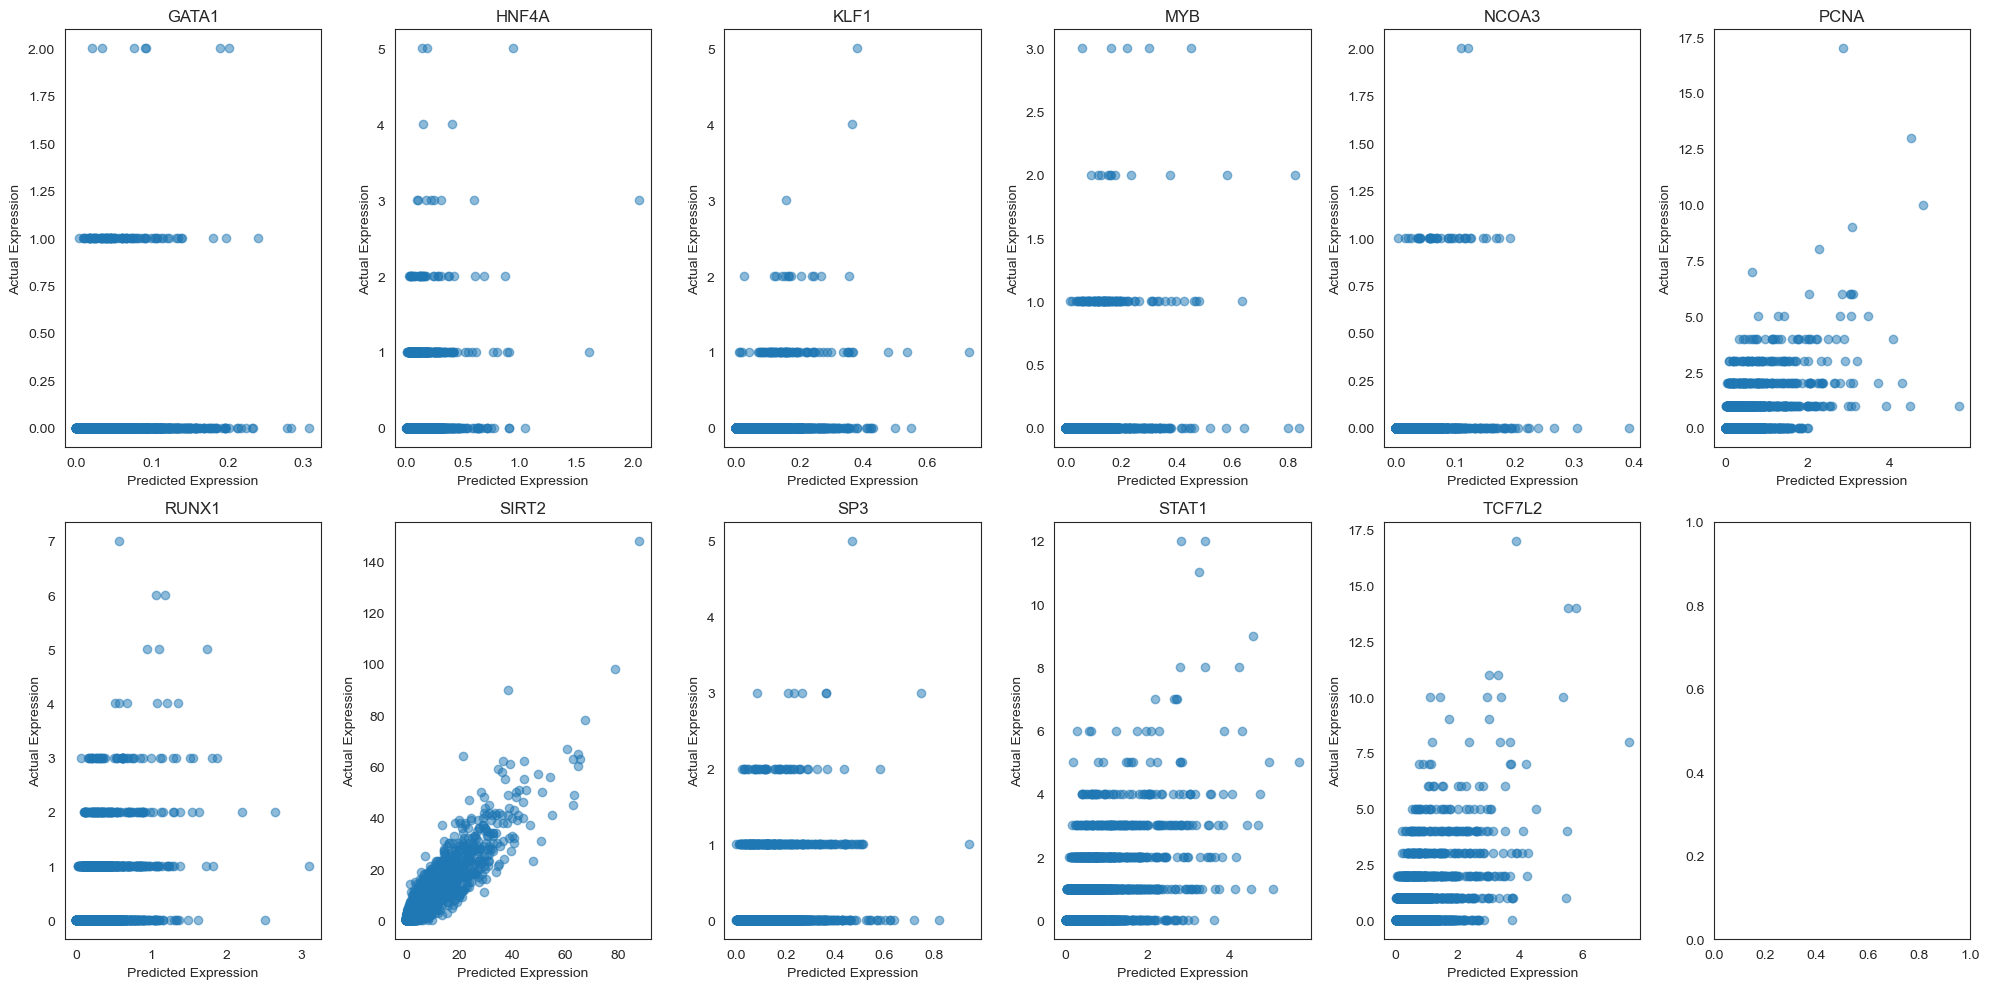

In [42]:
# Compare posterior mean predictions across 13 genes 
fig, ax = plt.subplots(2, 6, figsize=(20, 10))

for i, gene in enumerate(target_genes):
    curr_ax = ax[i // 6][i % 6]
    curr_ax.scatter(test_avg[:, i], Y_test[:, i], alpha=0.5)
    curr_ax.set_title(gene)
    curr_ax.set_xlabel('Predicted Expression')
    curr_ax.set_ylabel('Actual Expression')

plt.tight_layout()

Often, we are not able to accurately predict gene expressions for individual cells. However, many papers evaluate at the bulk level instead. That is, they evaluate how well the model predicts the average expression of each gene across a collection of similar cells. We evaluate our model in this way below since it is more relevant to the downstream task of understanding the effects of a drug at the tissue level.

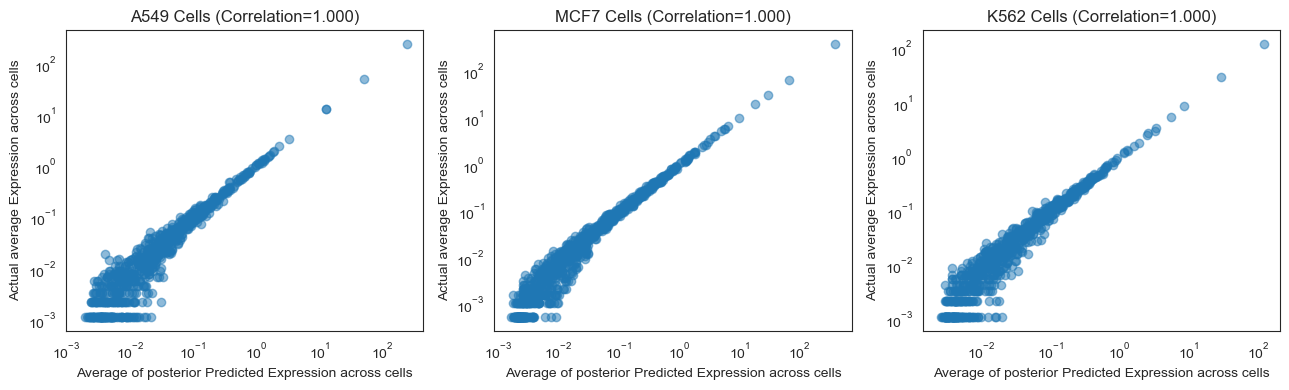

In [29]:
# Compare posterior mean predictions across all genes 
# Average gene expression comparison https://www.nature.com/articles/s41592-019-0494-8/figures/2

# Segment by cell type
fig, ax = plt.subplots(1, 3, figsize=(13, 4))
for i, cell_type in enumerate(['A549', 'MCF7', 'K562']):
    cell_type_mask = torch.tensor(drug_data[~train_mask.numpy()].obs['cell_type'].values == cell_type)
    test_avg_bulk = test_avg[cell_type_mask].mean(dim=0)

    ax[i].scatter(test_avg_bulk, Y_test[cell_type_mask].mean(dim=0), alpha=0.5)
    ax[i].set_xlabel('Average of posterior Predicted Expression across cells')
    ax[i].set_ylabel('Actual average Expression across cells')
    ax[i].set_title(f'{cell_type} Cells (Correlation={pearsonr(test_avg_bulk, Y_test[cell_type_mask].mean(dim=0))[0]:.3f})')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    plt.tight_layout()

Once we look at how our model performs at the bulk level, we see that the predictions are quite good. 

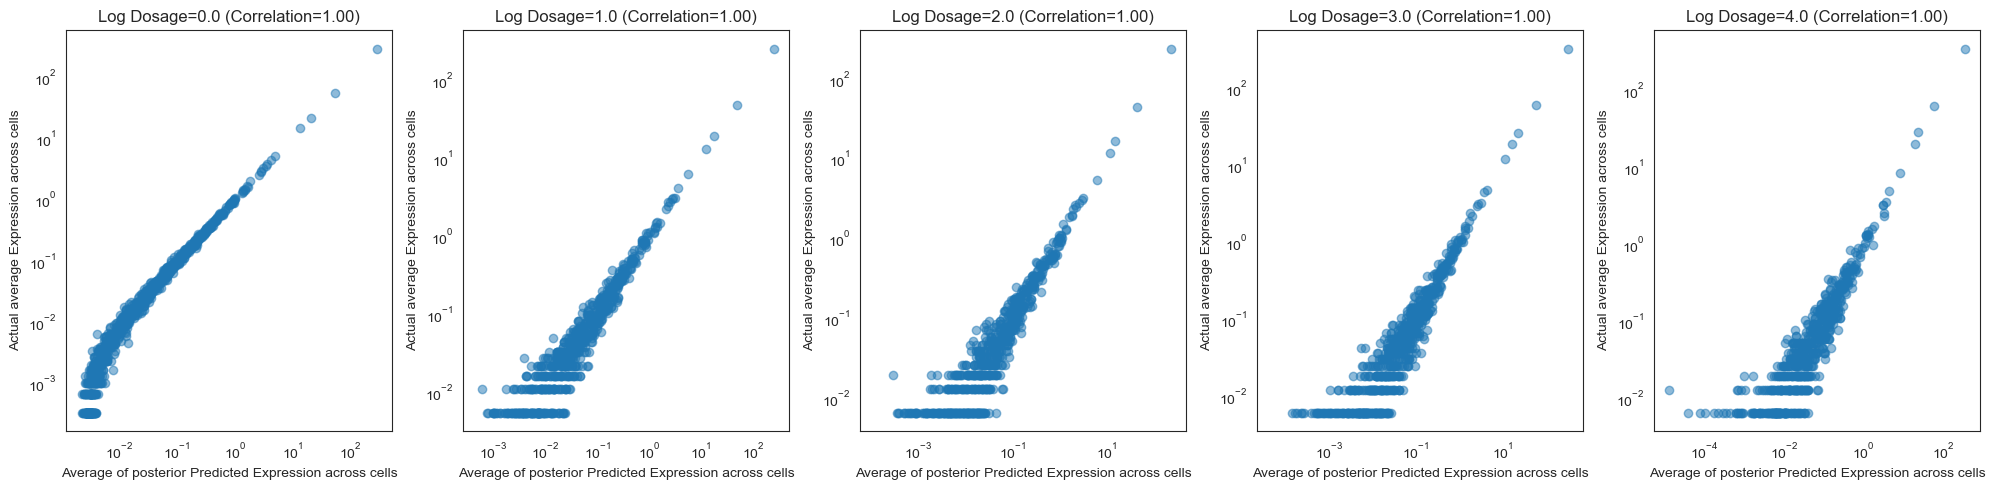

In [30]:
# Group cells by log dosage and then compare average expressions with the model
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i, log_dose_level in enumerate([0., 1., 2., 3., 4.]):
    dose_level_mask = torch.isclose(T_test, torch.tensor(log_dose_level), atol=.2)
    test_avg_bulk = test_avg[dose_level_mask].mean(dim=0)

    ax[i].scatter(test_avg_bulk, Y_test[dose_level_mask].mean(dim=0), alpha=0.5)
    ax[i].set_xlabel('Average of posterior Predicted Expression across cells')
    ax[i].set_ylabel('Actual average Expression across cells')
    ax[i].set_title(f'Log Dosage={log_dose_level} (Correlation={pearsonr(test_avg_bulk, Y_test[dose_level_mask].mean(dim=0))[0]:.2f})')
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
plt.tight_layout()

## Computing causal queries

For each gene in `target_genes`, we would like to estimate the causal effect of Pracinostat (SB939) on the gene's expression level at each dosage level $T \in \{0, 10^1, 10^2, 10^3, 10^4\}$. Since we only observe the expression level of each cell at a particular dosage, we impute the values of the remaining dosages using our model.

### Causal Query: Average treatment effect (ATE)

The average treatment effect summarizes, on average, how much the drug changes the expression level of a gene, $ATE(t) = \mathbb{E}[Y=1|do(T=t)] - \mathbb{E}[Y=1|do(T=0)]$. The `do` notation indicates that the expectations are taken according to *intervened* versions of the model, with $T$ set to a particular value. Note from our [tutorial](tutorial_i.ipynb) that this is different from conditioning on $T$ in the original `causal_model`, which assumes $X$ and $T$ are dependent.

In this setting, the ATE tells us how much lower or higher a gene's expression level is when the drug is administered at a particular dosage level relative to when the drug is not administered. Here, we are interested in the average over the entire population of cells. Other estimands, such as the conditional average treatment effect, may be interested in the average effect for cells with particular attributes of interest.

To implement this query in ChiRho, we extend our `DrugPerturbationModel` model by applying two interventions, `do(actions={"drug":0})` and `do(actions={"drug": t})`, and then sampling jointly from counterfactual worlds using the `MultiWorldCounterfactual` handler. Recall from the [tutorial](tutorial_i.ipynb) that the `MultiWorldCounterfactual` handler modifies the execution of the causal model to sample jointly from the observational and all counterfactual worlds induced by an intervention.

In [31]:
class DrugPerturbationATE(pyro.nn.PyroModule):
    def __init__(self, model: DrugPerturbationModel, X_pop: torch.tensor):
        super().__init__()
        self.model = model
        # sample population confounders to average over
        self.X_pop = X_pop

    def forward(self, dose_levels: tuple):
        dose_levels = (torch.tensor(0.),) + tuple(torch.as_tensor(dose_level) for dose_level in dose_levels)

        with MultiWorldCounterfactual(), do(actions={"drug": dose_levels}), \
                condition(data=dict(observed_confounders=self.X_pop[:, None, :])):
            expressions = self.model()
            expressions_dose = gather(expressions, IndexSet(drug=set(range(2, len(dose_levels) + 1)))) # expressions predicted by model at doses > 0
            expressions_vehicle = gather(expressions, IndexSet(drug={1})) # expressions predicted by model at dose 0 (vehicle)
            return pyro.deterministic("ATEs", (expressions_dose - expressions_vehicle).mean(dim=-2))

ate_model = DrugPerturbationATE(
    DrugPerturbationModel(num_cells=Y_train.shape[0], num_genes=Y_train.shape[1], num_observed_confounders=X_train.shape[1]),
    X_pop=X_train
)
ate_predictive = pyro.infer.Predictive(ate_model, guide=guide_train, num_samples=500, return_sites=("ATEs",))

log_dose_levels = (1., 2., 3., 4.)
ate_samples = ate_predictive(log_dose_levels)['ATEs'].squeeze()

In [33]:
# Issues w/ shuffling
target_mask_reindexed = drug_data.var.index.isin(target_genes)
target_genes_reindexed = drug_data.var.index[target_mask_reindexed] 

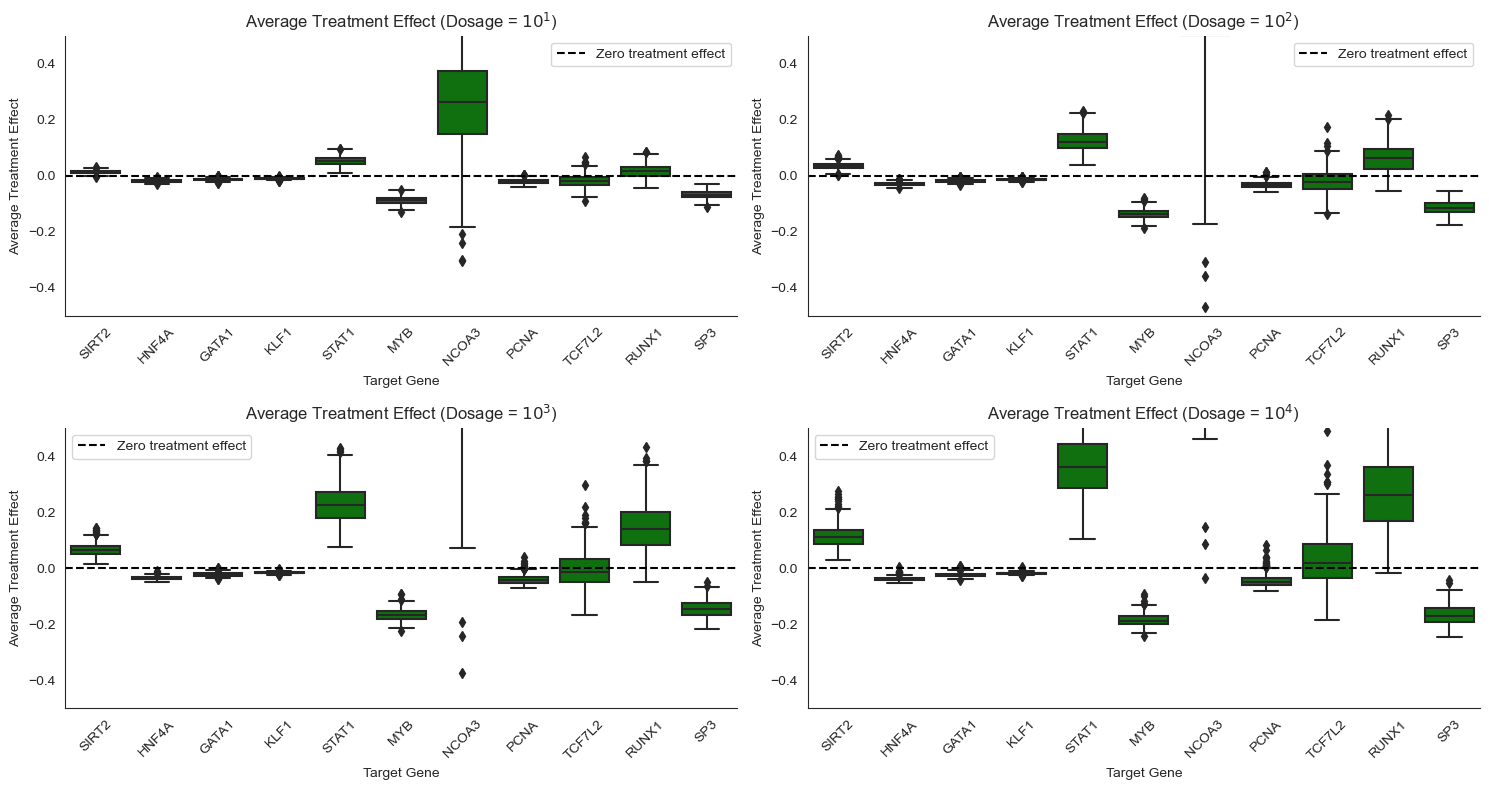

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

for i, dose_level in enumerate(log_dose_levels):
    curr_ax = ax[i // 2][i % 2]
    sns.boxplot(pd.DataFrame(ate_samples[:, i, target_mask_reindexed], columns=target_genes_reindexed), color='green', ax=curr_ax)
    curr_ax.set_title(f'Average Treatment Effect (Dosage = $10^{int(dose_level)}$)')
    curr_ax.axhline(0, color='black', linestyle='--', label='Zero treatment effect')
    curr_ax.set_xlabel('Target Gene')
    for tick in curr_ax.get_xticklabels():
        tick.set_rotation(45)
    curr_ax.set_ylabel('Average Treatment Effect')
    curr_ax.legend()
    curr_ax.set_ylim(-.5, .5)
    sns.despine()

plt.tight_layout() 


The plot above provides the uncertainity across the average treatment effect for each gene. The upper and lower lines on each boxplot form a 50% credible interval for the average treatment effect. Although Pracinostat (SB939) is an inhibitor, the drug sometimes is estimated to increase expression levels in certain genes. For example, SIRT2 exhibits the largest positive effect. This finding is consistent with Srivatsan (2020) (see Figure 5b), and is likely due to off-target effects.

### Causal Query: Conditional average treatment effect (CATE)

The ATE summarizes how much the drug changes the expression level of a gene on average, but certain types of cells might respond differently to the drug. In this setting we wish to compute the *conditional average treatment effect*, $CATE(t) = \mathbb{E}[Y=1|do(T=t), X=x] - \mathbb{E}[Y=1|do(T=0), X=x]$, which controls for cell-specific confounders $X$.

In words, in this setting the CATE tells us how much lower or higher a gene's expression level is when the drug is administered at a particular dosage level relative to when the drug is not administered, *for cells with the same set of confounders*. Here, we are interested in the average only over that subpopulation of cells with the same value of the confounders.

In [30]:
class DrugPerturbationCATE(pyro.nn.PyroModule):
    def __init__(self, model: DrugPerturbationModel):
        super().__init__()
        self.model = model

    def forward(self, dose_levels: tuple, X: torch.tensor, T: torch.tensor, Y: torch.tensor):
        dose_levels = (torch.tensor(0.),) + tuple(torch.as_tensor(dose_level) for dose_level in dose_levels)

        with MultiWorldCounterfactual(), do(actions={"drug": dose_levels}), \
                condition(data={"observed_confounders": X[:, None, :], "drug": T[..., None], "gene_expression": Y}):
            expressions = self.model()
            expressions_dose = gather(expressions, IndexSet(drug=set(range(2, len(dose_levels) + 1)))) # expressions predicted by model at doses > 0
            expressions_vehicle = gather(expressions, IndexSet(drug={1})) # expressions predicted by model at dose 0 (vehicle)
            return pyro.deterministic("CATEs", (expressions_dose - expressions_vehicle))

In [31]:
log_dose_levels = (1., 2., 3., 4.)
cell_types = ['A549', 'MCF7', 'K562']

# Conditional average treatment effect for each cell
cate_model = DrugPerturbationCATE(
        DrugPerturbationModel(num_cells=X_test.shape[0], num_genes=Y_test.shape[1], num_observed_confounders=X_test.shape[1])
    )

cate_predictive = pyro.infer.Predictive(cate_model, guide=guide_test_obs, num_samples=500, return_sites=("CATEs",))
cate_for_each_cell = cate_predictive(log_dose_levels, X_test, T_test, Y_test)['CATEs'].squeeze()

# To get conditional average treatment by cell type, we average cate_predictive across the subset of cells that are of each cell type
cate_samples = {}
for cell_type in cell_types:
    cell_type_mask = torch.tensor(drug_data.obs['cell_type'].values == cell_type)[~train_mask]
    
    # condition on cell type, average over other covariates by averaging over cells
    # cate_samples is matrix of size num posterior samples x num dosages x num cells x num genes
    cate_samples[cell_type] = cate_for_each_cell[:, :, cell_type_mask, :].mean(dim=-2)

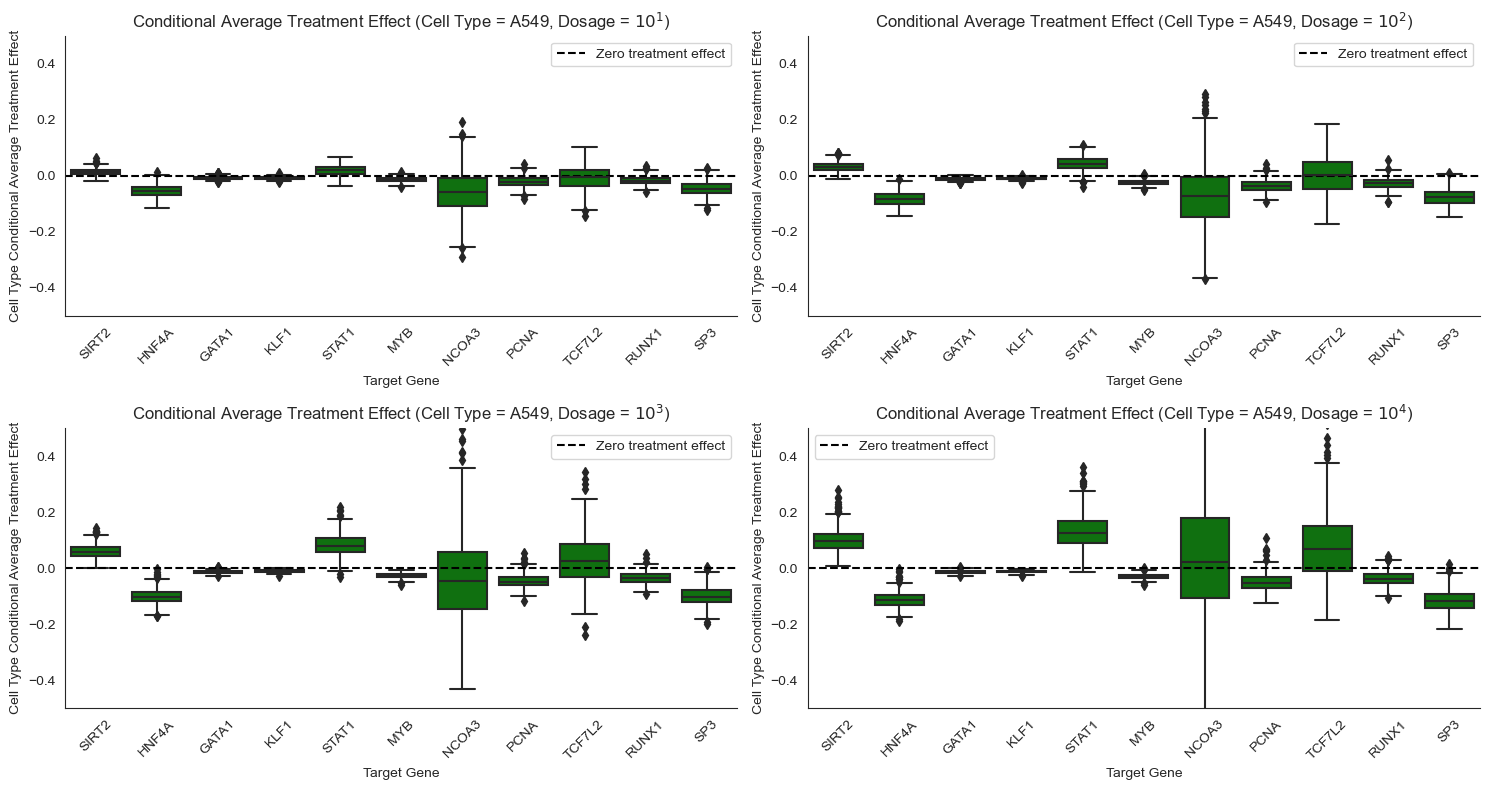

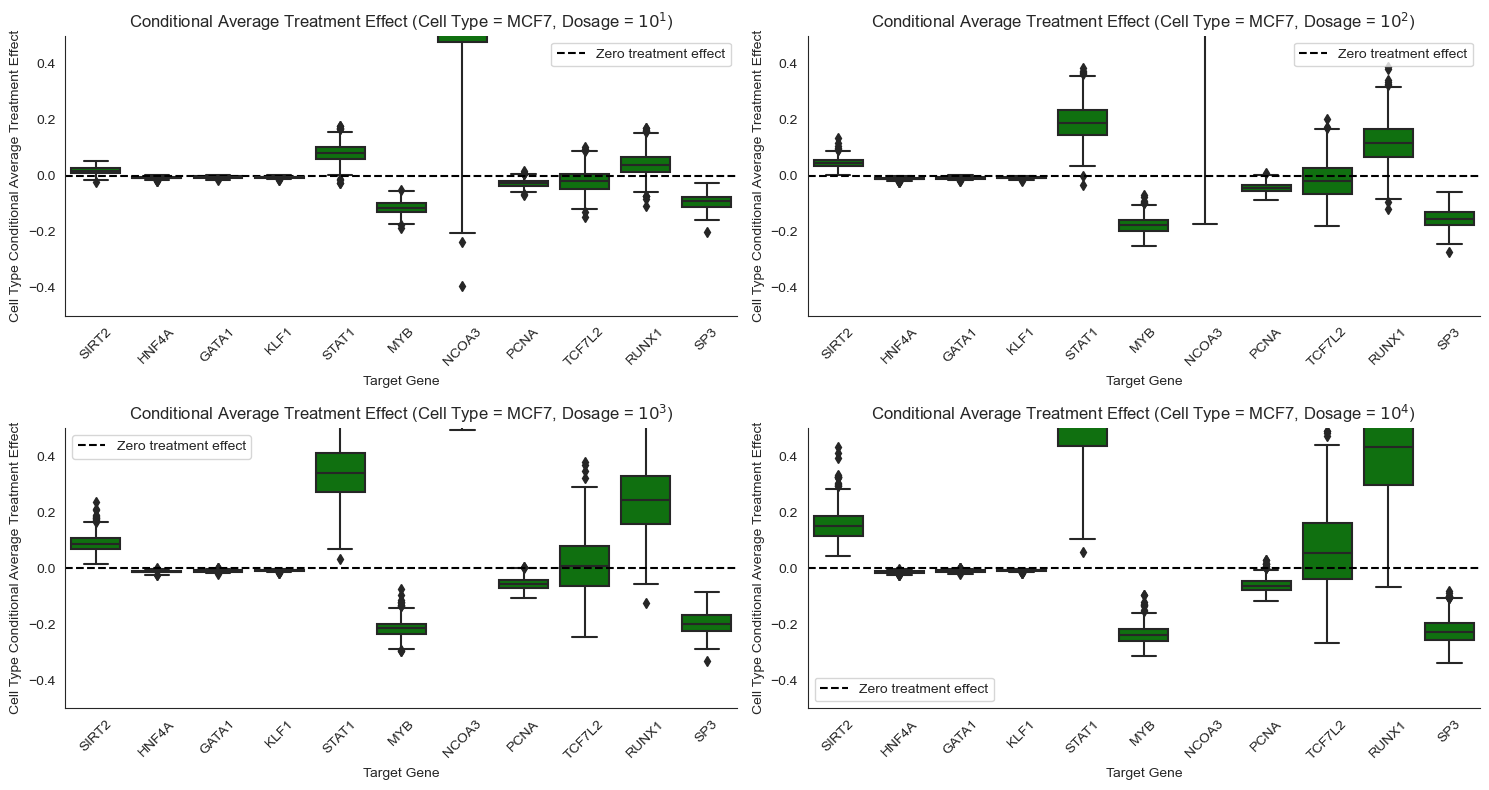

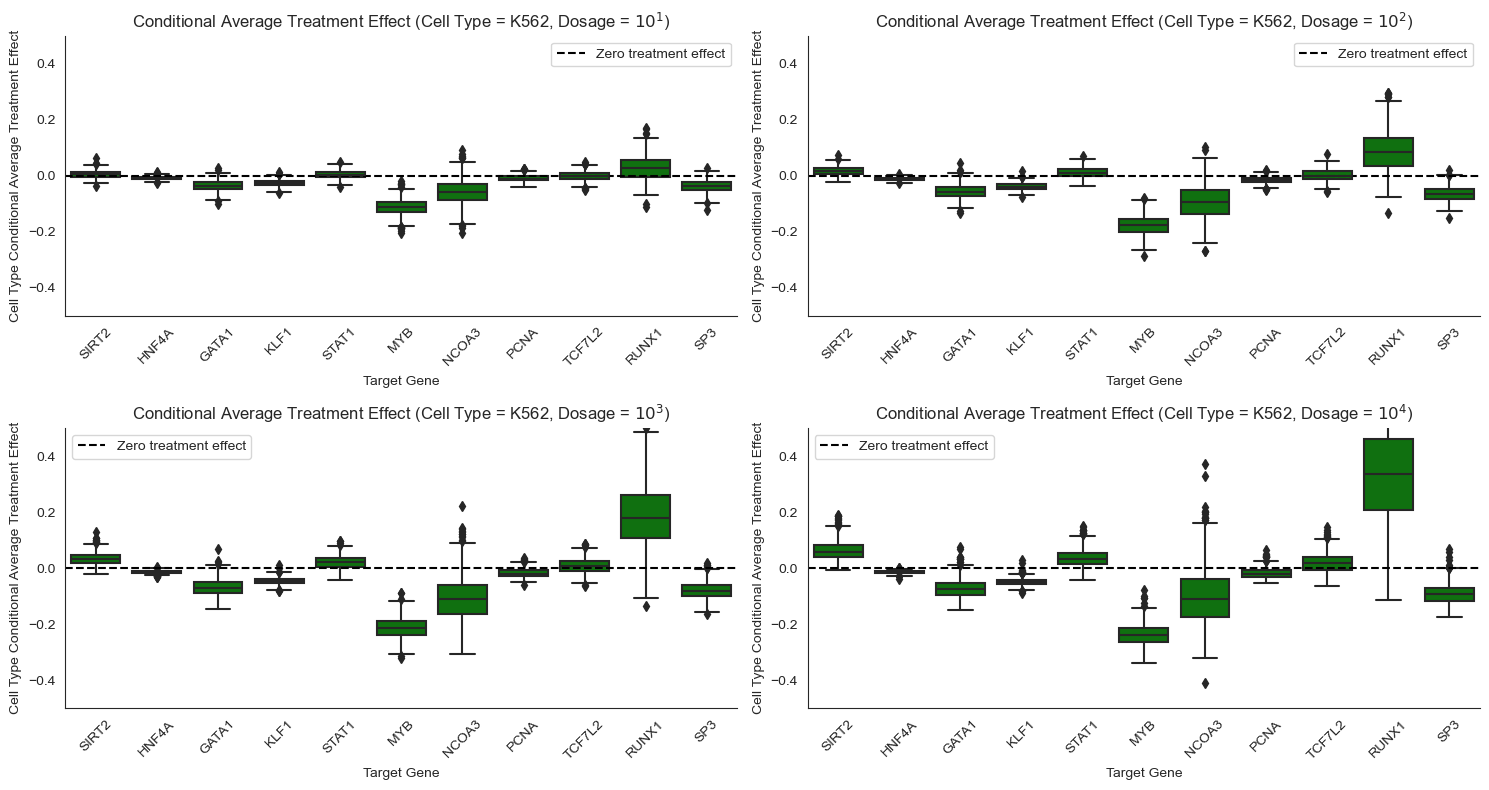

In [36]:
for cell_type in cell_types:
    fig, ax = plt.subplots(2, 2, figsize=(15, 8))

    for i, dose_level in enumerate(log_dose_levels):
        curr_ax = ax[i // 2][i % 2]
        sns.boxplot(pd.DataFrame(cate_samples[cell_type][:, i, target_mask_reindexed], columns=target_genes_reindexed), color='green', ax=curr_ax)
        curr_ax.set_title(f'Conditional Average Treatment Effect (Cell Type = {cell_type}, Dosage = $10^{int(dose_level)}$)')
        curr_ax.axhline(0, color='black', linestyle='--', label='Zero treatment effect')
        curr_ax.set_xlabel('Target Gene')
        for tick in curr_ax.get_xticklabels():
            tick.set_rotation(45)
        curr_ax.set_ylabel('Cell Type Conditional Average Treatment Effect')
        curr_ax.set_ylim(-.5, .5)
        curr_ax.legend()
        sns.despine()

    plt.tight_layout()

We conclude by including Figure 5B from Srivatsan (2020), which shows how HDAC inhibitors such as Pracinostat (SB939) affect the expression of other genes such as SIRT2. From the figures above, we see that are model correctly estimates that Pracinostat (SB939) has a positive effect on SIRT2 expression. TODO: add more discussion about biology here and how it relates to findings above

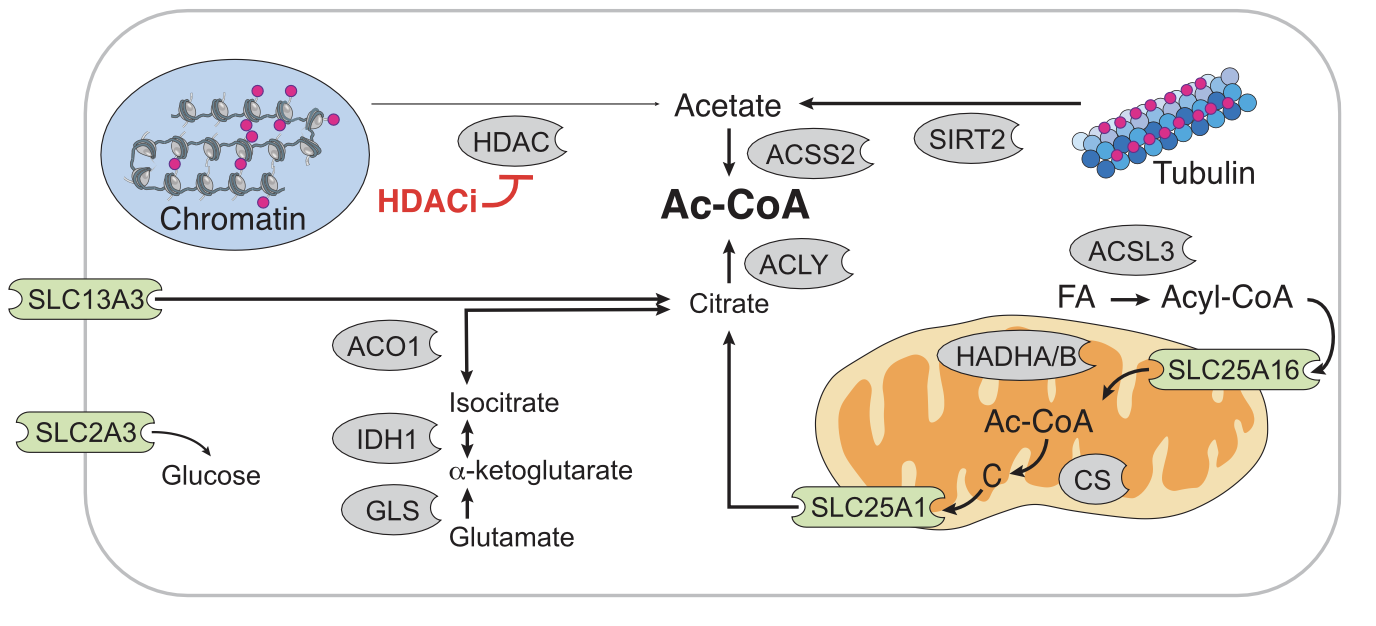

In [45]:
# Figure 5B from Srivatsan (2020)
# Diagram of the roles of genes from (A) in cytoplasmic acetyl-CoA regulation. 
# Red circles indicate acetyl groups. Enzymes are shown in gray. Transporters are shown in green 
# (FA, fatty acid; Ac-CoA, acetyl-CoA; C, citrate).
Image('./figures/sciplex_fig5b.png', width=700)

# References

Sanjay R., Srivatsan et al., "Massively multiplex chemical transcriptomics at single-cell resolution". Science, 2020. https://www.science.org/doi/10.1126/science.aax6234

Hyun-Jung Kim, Suk-Chul Bae. "Histone deacetylase inhibitors: molecular mechanisms of action and clinical trials as anti-cancer drugs". American Journal of Translational Research, 2011. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3056563/

Guo Li, Yuan Tian, Wei-Guo Zhu. "The Roles of Histone Deacetylases and Their Inhibitors in Cancer Therapy". Frontiers in Cell and Developmental Biology, 2020. https://www.frontiersin.org/articles/10.3389/fcell.2020.576946/full

HUGO Gene Nomenclature Committee. Histone deacetylase superfamily. HGNC, 2020. https://www.genenames.org/data/genegroup/#!/group/937

Daryl C. Drummond et al. "Clinical development of histone deacetylase inhibitors as anticancer agents". Annual Review of Pharmacology and Toxicology, 2005. https://www.annualreviews.org/doi/10.1146/annurev.pharmtox.45.120403.095825.

Xiang-Jiao Yang, Edward Seto. "HATs and HDACs: from structure, function and regulation to novel strategies for therapy and prevention". Oncogene, 2007. https://www.nature.com/articles/1210599.